# Importing Libraries and Setting Up Environment
This section imports all the necessary libraries and modules required for the notebook. It includes libraries for data handling, clustering, visualization, and other utilities. Additionally, it sets up the system path for importing local modules.

In [1]:
from rag_eval import ChunkDataHandler
from fcgb.cfg.precompiled import get_llm, get_embedding_model

import os
import json
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from sklearn.cluster import SpectralClustering
from scipy.linalg import eigh
import numpy as np
from collections import defaultdict
import sys
sys.path.append("..")
import math

import matplotlib.pyplot as plt

## Data Handler Initialization
The `ChunkDataHandler` class is initialized here. This class is responsible for managing document chunks and their evaluations. It provides methods to load evaluated documents and other utilities for processing.

In [2]:
data_handler = ChunkDataHandler(output_path='../data')

## Loading Evaluated Documents
Using the `ChunkDataHandler` instance, we load the evaluated documents. These documents contain preprocessed data that will be used for further analysis and clustering.

In [3]:
eval_docs = data_handler._evaluated_docs()

## Embedding Model Setup
Here, we initialize the embedding model. This model generates vector representations (embeddings) for document chunks, which are essential for similarity calculations and clustering.

In [4]:
embedding_model = get_embedding_model(embedding_model='google')

## Document Loading and Chunking
The `LoadDocAndChunk` class is defined in this section. It provides methods to load documents, split them into smaller chunks, and manage metadata. The class also includes utilities for handling PDFs and splitting text into manageable pieces.

In [5]:
class LoadDocAndChunk:
    def __init__(
            self,
            data_path: str,
            chunk_size: int = 600,
            chunk_overlap: int = 0,
    ):
        self.data_path = data_path
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap

        self.docs_path = os.path.join(self.data_path, 'docs')
        self.metadata_path = os.path.join(self.data_path, 'docs_metadata')

        self._set_text_splitter()

    def _set_text_splitter(self):
        """
        Initializes the text splitter for chunking documents.
        """
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=self.chunk_size,
            chunk_overlap=self.chunk_overlap,
            length_function=len
        )

    def load_pdf(self, doc_name: str):
        """
        Loads a PDF document and extracts its content.
        """
        path = os.path.join(self.docs_path, doc_name + '.pdf')

        try:
            loader = PyPDFLoader(path, mode='single', extraction_mode='plain')
            content = loader.load()[0].page_content
        except Exception as e:
            print(f"Error loading PDF {doc_name}: {e}")
            content = None

        return content
    
    def load_metadata(self, doc_name: str):
        """
        Loads metadata for a document.
        """
        path = os.path.join(self.metadata_path, doc_name + '.json')
        try:
            with open(path, 'r') as f:
                metadata = json.load(f)
        except Exception as e:
            print(f"Error loading metadata for {doc_name}: {e}")
            metadata = None

        return metadata
    
    def split_content(self, content: str):
        """
        Splits the content into chunks.
        """
        if not content:
            return []

        chunks = self.text_splitter.split_text(content)
        return chunks
    
    def __call__(self, doc_name: str):
        """
        Loads and splits a PDF document into chunks.
        """
        content = self.load_pdf(doc_name)
        chunks = self.split_content(content)
        metadata = self.load_metadata(doc_name)
        return {
            'doc_name': doc_name,
            'content': content,
            'chunks': chunks,
            'metadata': metadata
        }
    
def embs_cosine_similarity(a: np.array, b: np.array) -> np.array:
    """
    Computes the cosine similarity between two sets of embeddings.
    """
    norm_a = np.linalg.norm(a, axis=1, keepdims=True)
    norm_b = np.linalg.norm(b, axis=1, keepdims=True)
    return np.dot(a, b.T) / (norm_a * norm_b.T)

def group_points_by_cluster(cluster_labels):
    """
    Groups indexes of points by their cluster numbers.
    
    Args:
        cluster_labels (list or np.ndarray): List of cluster numbers for each point.
    
    Returns:
        list of lists: Each inner list contains indexes of points belonging to the same cluster.
    """
    cluster_groups = defaultdict(list)
    
    for index, cluster in enumerate(cluster_labels):
        cluster_groups[cluster].append(index)
    
    # Convert defaultdict to a list of lists
    return list(cluster_groups.values())

def construct_weighting_kernel(similarity, sigma=1.0):
    """
    Constructs a weighting kernel for the affinity matrix.
    
    Args:
        similarity (tf.Tensor): The affinity matrix.
        sigma (float): The standard deviation for the Gaussian kernel.
    
    Returns:
        tf.Tensor: The weighting kernel.
    """
    # Get the shape of the similarity matrix
    n = similarity.shape[0]
    
    # Create a distance matrix from the diagonal
    row_indices, col_indices = np.indices((n, n))
    distance_from_diagonal = np.abs(row_indices - col_indices)
    
    # Apply Gaussian kernel
    weighting_kernel = np.exp(-distance_from_diagonal**2 / (2 * sigma**2))
    
    return weighting_kernel.astype(similarity.dtype)

def adjust_clusters_to_consecutive(clusters_collections):
    """
    Adjusts clusters to ensure each cluster has consecutive points and no overlaps.

    Args:
        clusters (list of lists): List of clusters, where each cluster contains indexes of points.

    Returns:
        list of lists: Adjusted clusters with consecutive points.
    """
    # Flatten the clusters into a single list with cluster labels
    point_to_cluster = {}
    for cluster_idx, cluster in enumerate(clusters_collections):
        for point in cluster:
            point_to_cluster[point] = cluster_idx

    # Sort points by their index
    sorted_points = sorted(point_to_cluster.keys())

    # Initialize adjusted clusters
    adjusted_clusters = [[] for _ in clusters_collections]

    # Iterate through sorted points and assign them to clusters
    current_cluster = None
    for point in sorted_points:
        cluster_idx = point_to_cluster[point]
        if current_cluster is None or cluster_idx != current_cluster:
            current_cluster = cluster_idx
        adjusted_clusters[current_cluster].append(point)

    # Remove empty clusters
    adjusted_clusters = [cluster for cluster in adjusted_clusters if cluster]

    return adjusted_clusters

def form_clusters_idxs(clusters_collections):
    return np.array([cl_id for cl_id, idxs in enumerate(clusters_collections) for _ in idxs])

## Chunker Initialization
An instance of the `LoadDocAndChunk` class is created here. This instance will be used to load and process document data, including splitting documents into chunks.

In [7]:
chunker = LoadDocAndChunk(data_path='../data', chunk_size=600, chunk_overlap=0)

### Loading and Chunking a Document
In this step, a specific document is loaded, split into chunks, and the number of chunks is printed. This demonstrates the chunking process in action.

In [268]:
doc_data = chunker(eval_docs[4])
print(f"Loaded document: {doc_data['doc_name']} with {len(doc_data['chunks'])} chunks.")

Loaded document: 2403.05408v2 with 62 chunks.


### Generating Chunk Embeddings
The embeddings for the document chunks are generated using the embedding model. These embeddings are numerical representations of the text, which are used for similarity calculations and clustering.

In [209]:
chunk_embeddings = embedding_model.embed_documents(doc_data['chunks'])

Retrying vertexai.language_models._language_models._TextEmbeddingModel.get_embeddings in 4.0 seconds as it raised ServiceUnavailable: 503 Getting metadata from plugin failed with error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')).
Retrying vertexai.language_models._language_models._TextEmbeddingModel.get_embeddings in 4.0 seconds as it raised ServiceUnavailable: 503 recvmsg:Connection reset by peer.


In [210]:
chunk_embeddings = np.array(chunk_embeddings).astype(np.float32)

### Calculating Chunk Similarity
The cosine similarity between chunk embeddings is calculated. This results in a similarity matrix, which quantifies the relationships between different chunks.

In [211]:
chunk_similarity = embs_cosine_similarity(chunk_embeddings, chunk_embeddings)
print("Chunk similarity shape:", chunk_similarity.shape) 

Chunk similarity shape: (70, 70)


### Visualizing Chunk Similarity
A heatmap is used to visualize the similarity matrix. This provides an intuitive understanding of how similar the chunks are to each other.

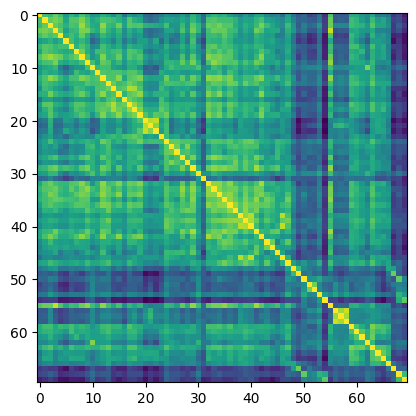

In [212]:
plt.imshow(chunk_similarity)

## Clustering Chunks
Spectral clustering is applied to the similarity matrix to group similar chunks together. Depending on the `sequential_clustering` flag, a weighted kernel may be applied to the similarity matrix before clustering. The clusters are adjusted to ensure consecutive points.

In [213]:
sigma = 5.0 
clusters_num = math.ceil(len(chunk_embeddings)/sigma)
sequential_clustering = False

if sequential_clustering:
    weighting_kernel = construct_weighting_kernel(chunk_similarity, sigma=sigma)

    clustering = SpectralClustering(
        n_clusters=clusters_num, 
        affinity='precomputed',
        eigen_solver='arpack',
        assign_labels='discretize'
        ).fit((chunk_similarity * weighting_kernel))

    clusters_chunks_idxs = adjust_clusters_to_consecutive(group_points_by_cluster(clustering.labels_))
    cls = form_clusters_idxs(clusters_chunks_idxs)
else:
    clustering = SpectralClustering(
        n_clusters=clusters_num, 
        affinity='precomputed',
        eigen_solver='arpack',
        assign_labels='cluster_qr'
        ).fit(chunk_similarity)

    cls = clustering.labels_
    clusters_chunks_idxs = group_points_by_cluster(cls)

### Visualizing Clustering Results
The clustering results are visualized using heatmaps. These plots overlay the clustering results on the similarity matrix and display the valued clustering matrix.

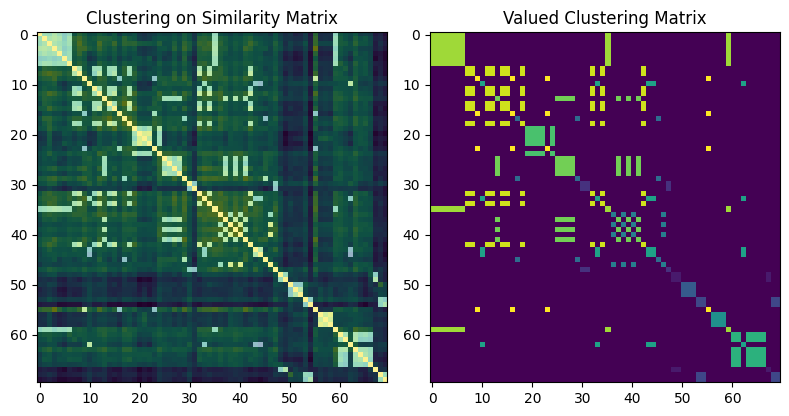

In [214]:
cls_matrix = (cls[:, np.newaxis] == cls[np.newaxis, :])
valued_cls_matrix = cls_matrix*(cls[:, np.newaxis] + 1)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(chunk_similarity)
axs[0].imshow(cls_matrix, cmap='gray', alpha=0.5)
axs[0].set_title('Clustering on Similarity Matrix')
axs[1].imshow(valued_cls_matrix, cmap='viridis')
axs[1].set_title('Valued Clustering Matrix')
plt.tight_layout()
plt.show()

In [215]:
clusters_chunks_idxs

[[0, 1, 2, 3, 4, 5, 6, 35, 59],
 [7, 8, 11, 12, 14, 15, 18, 32, 34, 42],
 [9, 16, 23, 55],
 [10, 33, 43, 44, 62],
 [13, 25, 26, 27, 28, 37, 39, 41],
 [17, 29, 45],
 [19, 20, 21, 22, 24],
 [30, 31, 47],
 [36, 38, 40, 46],
 [48, 49, 67],
 [50, 51, 52],
 [53, 54, 68, 69],
 [56, 57, 58],
 [60, 61, 63, 64, 65, 66]]

### Evaluating Clusters
The clusters are evaluated by comparing their labels with ground truth labels. Aggregated labels for each cluster are calculated and displayed to assess the clustering quality.

In [216]:
eval_data = data_handler.get_eval_file(doc_data['doc_name'])
labels = np.array([chunk_spec['labels'] for chunk_spec in eval_data['chunks_eval']]).astype(int)

In [217]:
clusters_labels = []

for cluster_idxs in clusters_chunks_idxs:
    cluster_labels = labels[cluster_idxs]
    # Aggregate labels by summing them up
    aggregated_labels = np.sum(cluster_labels, axis=0)

    clusters_labels.append(aggregated_labels)

clusters_labels = np.stack(clusters_labels, axis=0)
print(f"Clusters labels shape: {clusters_labels.shape}")

clusters_labels, 

Clusters labels shape: (14, 5)


(array([[2, 2, 2, 1, 1],
        [4, 6, 1, 0, 7],
        [3, 3, 2, 2, 3],
        [0, 1, 2, 0, 1],
        [0, 0, 3, 0, 1],
        [0, 1, 1, 0, 1],
        [0, 1, 0, 0, 4],
        [0, 0, 0, 0, 0],
        [0, 0, 2, 0, 0],
        [0, 0, 1, 1, 0],
        [0, 0, 0, 3, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]),)

In [218]:
# sequential clustering
np.sum(clusters_labels>0), np.sum(clusters_labels>1), np.sum(clusters_labels>2)

(np.int64(28), np.int64(16), np.int64(9))

In [219]:
# full clustering
np.sum(clusters_labels>0), np.sum(clusters_labels>1), np.sum(clusters_labels>2)

(np.int64(28), np.int64(16), np.int64(9))

### Identifying Representative Chunks
Functions are defined to identify the most representative chunks for each cluster. Representativeness is determined based on proximity to the cluster centroid.

In [222]:
# Retreives a chunk that is the most representative for the cluster
# Representativeness is defined as the chunk closest to the clusters centroid
def get_cluster_centroid(cluster_idxs, encoded_chunks):
    cluster_chunks = encoded_chunks[cluster_idxs]
    cluster_centroid = np.mean(cluster_chunks, axis=0, keepdims=True)
    return cluster_centroid, cluster_chunks

def get_centroid_representative_chunk(cluster_idxs, encoded_chunks):
    cluster_centroid, cluster_chunks = get_cluster_centroid(cluster_idxs, encoded_chunks)
    similarities = np.squeeze(embs_cosine_similarity(cluster_chunks, cluster_centroid), axis=1)
    most_representative_idx = np.argmax(similarities)
    global_idx = cluster_idxs[most_representative_idx]
    return global_idx

# Get representative chunks from clusters for each query based on similarity score
def get_representative_chunks_for_queries(cluster_idxs, query_similarity):
    chunk_similarities = query_similarity[cluster_idxs]
    most_representative_idx = np.argmax(np.sum(chunk_similarities, axis=-1), axis=0)
    global_idx = cluster_idxs[most_representative_idx]
    return global_idx

In [221]:
representational_chunks_idxs = [get_centroid_representative_chunk(cluster_chunks_idxs, chunk_embeddings) for cluster_chunks_idxs in clusters_chunks_idxs]
print("Representative chunks indexes:", representational_chunks_idxs)

Representative chunks indexes: [1, 12, 9, 33, 37, 29, 20, 30, 40, 49, 52, 69, 58, 63]


In [222]:
queries_embeddings = np.array(embedding_model.embed_documents(doc_data['metadata']['queries']))

### Query Similarity Analysis
The similarity between chunk embeddings and query embeddings is calculated. Representative chunks for queries are identified based on their similarity scores.

In [223]:
query_similarity = embs_cosine_similarity(chunk_embeddings, queries_embeddings)

In [224]:
representational_query_chunks_idxs = [get_representative_chunks_for_queries(cluster_chunks_idxs, query_similarity) for cluster_chunks_idxs in clusters_chunks_idxs]
print("Representative query chunks indexes:", representational_query_chunks_idxs)

Representative query chunks indexes: [2, 8, 55, 33, 41, 29, 19, 47, 36, 48, 50, 53, 58, 63]


In [225]:
representational_chunks_embeddings = chunk_embeddings[representational_chunks_idxs]
representational_query_chunks_embeddings = chunk_embeddings[representational_query_chunks_idxs]
print("Representative chunks embeddings shape:", representational_chunks_embeddings.shape)
print("Representative query chunks embeddings shape:", representational_query_chunks_embeddings.shape)

Representative chunks embeddings shape: (14, 768)
Representative query chunks embeddings shape: (14, 768)


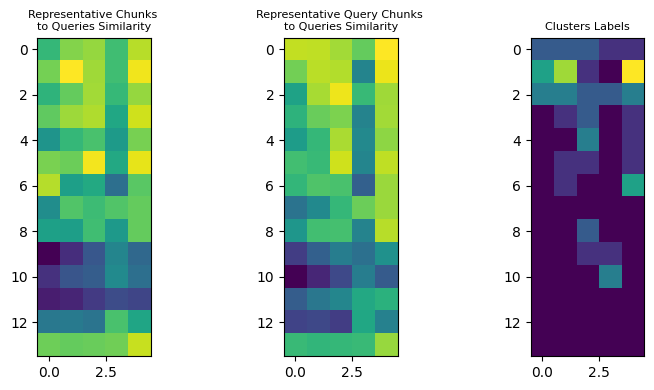

In [226]:
representational_chunks2query_similarity = embs_cosine_similarity(representational_chunks_embeddings, queries_embeddings)
representational_query2chunks_similarity = embs_cosine_similarity(representational_query_chunks_embeddings, queries_embeddings)

fig, axs = plt.subplots(1, 3, figsize=(8, 4))
axs[0].imshow(representational_chunks2query_similarity, cmap='viridis')
axs[0].set_title('Representative Chunks \nto Queries Similarity', fontsize=8)
axs[1].imshow(representational_query2chunks_similarity, cmap='viridis')
axs[1].set_title('Representative Query Chunks \nto Queries Similarity', fontsize=8)
axs[2].imshow(clusters_labels, cmap='viridis')
axs[2].set_title('Clusters Labels', fontsize=8)
plt.tight_layout()
plt.show()

### Visualizing Query Similarity
Heatmaps are displayed to visualize the similarity between representative chunks and queries. The clusters' labels are also visualized.

In [90]:
# load txt file
with open('../data/other/wiki_context.txt', 'r') as f:
    doc_content = f.read()

wiki_chunks = chunker.split_content(doc_content)
print(f"Number of wiki chunks: {len(wiki_chunks)}")

Number of wiki chunks: 68


## TF-IDF Based Retrieval
This section demonstrates the use of TF-IDF for retrieving relevant chunks based on queries. The TF-IDF vectorizer is used to calculate similarity scores, and the top results are displayed.

In [50]:
from langchain_community.retrievers import TFIDFRetriever

retriever = TFIDFRetriever.from_texts(doc_data['chunks'])

In [53]:
retriever.k = 10

In [41]:
doc_data.keys()

dict_keys(['doc_name', 'chunks', 'metadata'])

In [42]:
doc_data['metadata']['queries']

['What are the robust aggregation methods in Federated Learning (FL) that can be applied to healthcare data?',
 'How can robust aggregation methods detect and discard faulty or malicious local clients during Federated Learning training?',
 'Explain the impact of differential privacy (DP) on the learning convergence of different aggregation strategies in privacy-preserving Federated Learning.',
 'What are the different poisoning attacks that can affect the performance of robust Federated Learning aggregation strategies?',
 'How do privacy preserving methods perform alongside Byzantine-robust aggregation techniques in Federated Learning?']

In [54]:
retriever.invoke("differential privacy", )

[Document(metadata={}, page_content='hospital. Previous works have been proposed to control privacy\nexposure and provide reasonable data privacy guarantees. Here,\nwe highlight two main privacy preserving methods that are not\ncomputationally expensive and commonly used in the literature,\nnamely differential privacy (DP) [4] and k-anonymity [16].\n3 DATA PRIVACY COMBINED WITH ROBUST\nAGGREGATION FL\nData privacy methods (Section 2.4) are designed to protect the\nprivacy of user information by injecting a certain amount of noise.\nThis can mitigate the performance of robust aggregation methods'),
 Document(metadata={}, page_content='soning attacks. The results show that privacy preserving methods\ncan be successfully applied alongside Byzantine-robust aggregation\ntechniques. We observed in particular how using differential privacy\n(DP) did not significantly impact the final learning convergence of\nthe different aggregation strategies.\nCCS CONCEPTS\n• Applied computing →Health care

In [232]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
sentences = RecursiveCharacterTextSplitter(
            chunk_size=200,
            chunk_overlap=50,
            length_function=len
    ).split_text(doc_data['content'])

sentences = doc_data['chunks']
tfidf_array = vectorizer.fit_transform(sentences)
tfidf_array.shape

(70, 1660)

In [233]:
k = 6

queries = sentences#['differential privacy', 'Federated Learning', 'Byzantine-robust', 'privacy preserving Byzantine-robust aggregation']
query_vector = vectorizer.transform(queries)
results = cosine_similarity(tfidf_array, query_vector)



In [229]:
results.T.argsort()[:,:k]

array([[ 18,  26, 228, 231, 226, 227],
       [257,  17,  21, 226, 227, 228],
       [228, 227, 219, 218, 240, 241],
       ...,
       [  0,   1,   2,   3,  20,  21],
       [257,  21, 228, 240, 236, 231],
       [236, 240, 232, 241, 228,  59]], shape=(260, 6))

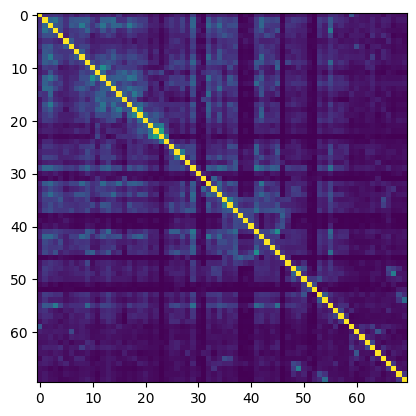

In [234]:
plt.imshow(results)

In [242]:
result_idxs = results.T.argsort()[:,-k:][:,::-1]
gathered_values = np.take_along_axis(results.T, result_idxs, axis=1)

In [243]:
gathered_values, result_idxs

(array([[1.        , 0.27087384, 0.1769115 , 0.16285068, 0.15383581,
         0.1420335 ],
        [1.        , 0.36352483, 0.34228118, 0.32939152, 0.32723882,
         0.32364083],
        [1.        , 0.41353915, 0.40416411, 0.38612814, 0.35073662,
         0.33402404],
        [1.        , 0.40352203, 0.36352483, 0.30868252, 0.27059504,
         0.25582657],
        [1.        , 0.26356884, 0.23996843, 0.23973777, 0.2282864 ,
         0.22289592],
        [1.        , 0.27484926, 0.16717893, 0.159866  , 0.15528362,
         0.15359014],
        [1.        , 0.28379138, 0.27484926, 0.25081837, 0.2157169 ,
         0.21052603],
        [1.        , 0.29077568, 0.271009  , 0.25594987, 0.25015874,
         0.23788024],
        [1.        , 0.41353915, 0.32926332, 0.32663248, 0.29077568,
         0.2863721 ],
        [1.        , 0.33147796, 0.32363613, 0.30868252, 0.29154978,
         0.27490829],
        [1.        , 0.49030423, 0.32467059, 0.30283609, 0.23616918,
         0.22957749],

In [202]:
cluster_tfidf_score = np.zeros((clusters_num,))
for cl in cls[np.reshape((result_idxs), (-1))]:
    cluster_tfidf_score[cl] += 1

cluster_tfidf_score

array([2., 6., 3., 3., 0., 0., 1., 2., 7.])

In [205]:
np.max(labels[np.reshape((result_idxs), (-1))], axis=1)

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0])

In [196]:
for i, query in enumerate(queries):
    print(f"Query: {query}\n")
    print("Top chunks:\n\n")
    for j, chunks_idx in enumerate(result_idxs[i]):
        chunk = sentences[chunks_idx]
        score = gathered_values[i][j]
        print(f"Chunk {j+1} (Score: {score:.4f}):\n")
        for line in chunk.split('\n'):
            print(line)
        print("\n---\n")
    print("\n\n----------------------\n\n")

Query: differential privacy

Top chunks:


Chunk 1 (Score: 0.3083):

for robust aggregation in Section 2; (3) we run an extensive set
of experiments to evaluate the impact of data privacy engineer-
ing (Differential Privacy, k-anonymity) on the accuracy of models

---

Chunk 2 (Score: 0.3075):

we highlight two main privacy preserving methods that are not
computationally expensive and commonly used in the literature,
namely differential privacy (DP) [4] and k-anonymity [16].

---

Chunk 3 (Score: 0.2921):

privacy approaches such as k-anonymity and differential privacy
(DP) over different learning tasks using tabular healthcare data. For
this, we have modeled two poisoning attack strategies and their

---

Chunk 4 (Score: 0.2813):

can be successfully applied alongside Byzantine-robust aggregation
techniques. We observed in particular how using differential privacy

---

Chunk 5 (Score: 0.2559):

This can mitigate the performance of robust aggregation methods
(Section 2.3) that rely on

## Graph-Based Analysis
Graphs are constructed to analyze the relationships between chunks and queries. Various graph-based metrics and visualizations are explored.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()

doc_data = chunker(eval_docs[9])
print(f"Loaded document: {doc_data['doc_name']} with {len(doc_data['chunks'])} chunks.")

eval_data = data_handler.get_eval_file(doc_data['doc_name'])
labels = np.array([chunk_spec['labels'] for chunk_spec in eval_data['chunks_eval']]).astype(int)

sentences = doc_data['chunks']
tfidf_array = vectorizer.fit_transform(sentences)
tfidf_array.shape

In [ ]:
k = 3

sentences_vector = vectorizer.transform(sentences)
results = cosine_similarity(tfidf_array, sentences_vector)

results *= 1-np.eye(results.shape[0])
results += np.eye(results.shape[0], k=1) + np.eye(results.shape[0], k=-1)

result_idxs = results.T.argsort()[:,-k:][:,::-1]
similarities = np.take_along_axis(results.T, result_idxs, axis=1)

print("result_idxs:", result_idxs.shape)
print("similarities:", similarities.shape)

result_idxs: (125, 3)
similarities: (125, 3)


In [ ]:
np.sum(similarities>0.25)/np.prod(similarities.shape)

np.float64(0.806)

In [ ]:
k_queries = 4

queries = phrases#doc_data['metadata']['queries']
queries_vector = vectorizer.transform(queries)
queries_results = cosine_similarity(tfidf_array, queries_vector)

queries_result_idxs = queries_results.T.argsort()[:,-k_queries:][:,::-1]
queries_similarities = np.take_along_axis(queries_results.T, queries_result_idxs, axis=1)

print("queries results", queries_results.shape)
print("queries_result_idxs:", queries_result_idxs.shape)
print("queries_similarities:", queries_similarities.shape)

queries results (125, 20)
queries_result_idxs: (20, 4)
queries_similarities: (20, 4)


### Community Detection
Community detection algorithms are applied to the graph to identify clusters of related chunks. The detected communities are evaluated and visualized.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

threshold = 0.2
query_idx = 1

query_labels = labels[:, query_idx]
for i, chunk_label in enumerate(query_labels):
    color = 'green' if chunk_label else 'red'
    border_width = 2 if i in queries_result_idxs[query_idx] else 0
    G.add_node(str(i), color=color, border_width=border_width, border_color='black')

for i, candidates in enumerate(zip(result_idxs, similarities)):
    for candidate_idx, scores in zip(*candidates):
        if scores > threshold:
            G.add_edge(str(i), str(candidate_idx))

In [ ]:
nx.degree(G)

DegreeView({'0': 3, '1': 4, '2': 2, '3': 1, '4': 2, '5': 2, '6': 2, '7': 1, '8': 2, '9': 3, '10': 4, '11': 3, '12': 2, '13': 1, '14': 2, '15': 0, '16': 3, '17': 2, '18': 0, '19': 3, '20': 2, '21': 1, '22': 1, '23': 2, '24': 2, '25': 3, '26': 2, '27': 2, '28': 3, '29': 4, '30': 2, '31': 4, '32': 3, '33': 5, '34': 3, '35': 1, '36': 3, '37': 3, '38': 2, '39': 4, '40': 2, '41': 4, '42': 2, '43': 3, '44': 3, '45': 2, '46': 2, '47': 5, '48': 4, '49': 2, '50': 3, '51': 2, '52': 1, '53': 2, '54': 4, '55': 2, '56': 1, '57': 2, '58': 3, '59': 3, '60': 3, '61': 4, '62': 3, '63': 2, '64': 2, '65': 3, '66': 5, '67': 5, '68': 2, '69': 2, '70': 2, '71': 4, '72': 3, '73': 2, '74': 6, '75': 2, '76': 4, '77': 5, '78': 5, '79': 2, '80': 2, '81': 1, '82': 4, '83': 5, '84': 7, '85': 5, '86': 2, '87': 2, '88': 4, '89': 3, '90': 2, '91': 1, '92': 2, '93': 2, '94': 2, '95': 1, '96': 0, '97': 1, '98': 2, '99': 0, '100': 2, '101': 2, '102': 4, '103': 3, '104': 2, '105': 4, '106': 2, '107': 8, '108': 3, '109': 7

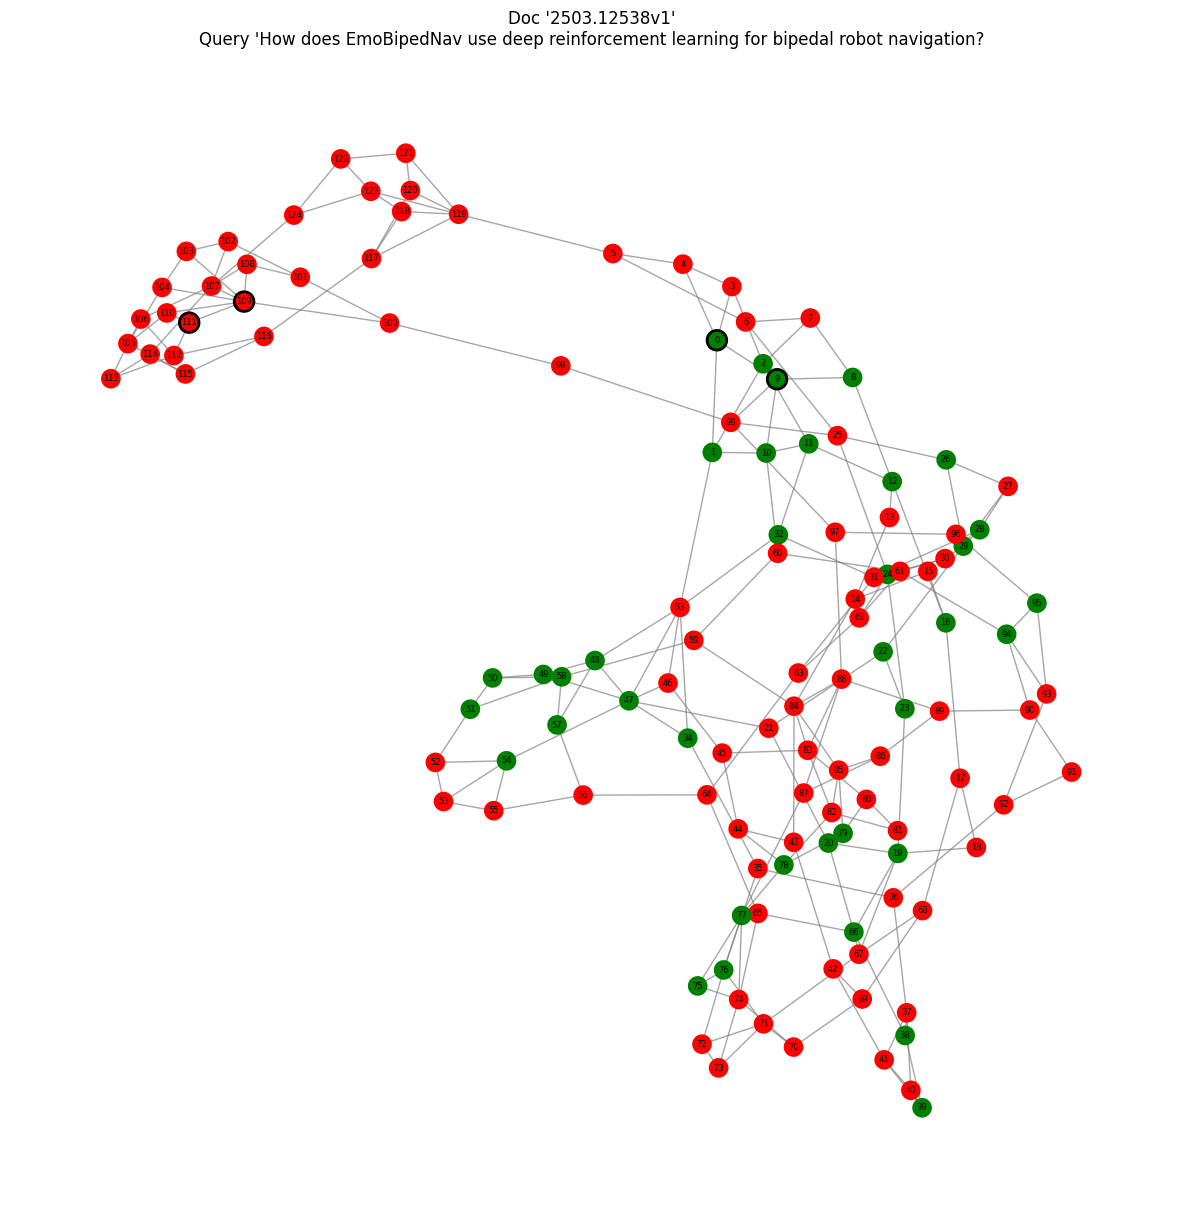

In [ ]:
node_colors = [G.nodes[node]['color'] for node in G.nodes()]
node_border_widths = [G.nodes[node]['border_width'] for node in G.nodes()]
node_border_colors = [G.nodes[node]['border_color'] for node in G.nodes()]
# Get node labels (the node names)
node_labels = {node: node for node in G.nodes()}

# Choose a layout algorithm (e.g., spring layout for a more natural look)
pos = nx.spring_layout(G)

# 5. Draw the graph
plt.figure(figsize=(15, 15)) # Adjust figure size for better visibility

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, linewidths=node_border_widths, edgecolors=node_border_colors) # Adjust node_size as needed

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7, edge_color="gray")

# Draw node labels
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=6, font_color="black")

plt.title(f"Doc '{doc_data['doc_name']}'\nQuery '{doc_data['metadata']['queries'][query_idx]}")
plt.axis("off") # Turn off the axis
plt.show()

### Generating Search Phrases
Using the detected communities, search phrases are generated to help retrieve relevant information from the document.

In [ ]:
G = nx.Graph()

threshold = 0.2
query_idx = 3

query_labels = labels[:, query_idx]
for i, chunk_label in enumerate(query_labels):
    border_width = 2 if chunk_label else 0
    G.add_node(str(i), border_width=border_width, border_color='black')

for i, candidates in enumerate(zip(result_idxs, similarities)):
    l=0
    for candidate_idx, scores in zip(*candidates):
        if (scores > threshold) | (l==0):
            G.add_edge(str(i), str(candidate_idx), weight=scores)
        l+=1

In [ ]:
communities = nx.community.louvain_communities(G, seed=123, resolution=2.0)
print(f"Number of communities: {len(communities)}")

Number of communities: 13


In [ ]:
communities_num = len(communities)

# colors for each community
colors = plt.get_cmap('tab20', communities_num).colors

# Create a color map for the nodes based on their community
node_colors = []
for i, community in enumerate(communities):
    for node in community:
        node_colors.append({'id': int(node), 'color': colors[i]})

# sort colors by node id
node_colors = [node['color'] for node in sorted(node_colors, key=lambda x: x['id'])]

In [ ]:
nx.betweenness_centrality(G.subgraph(communities[1]))

{'56': 0.0,
 '64': 0.2857142857142857,
 '32': 0.47619047619047616,
 '7': 0.0,
 '6': 0.0,
 '2': 0.2857142857142857,
 '25': 0.2857142857142857,
 '11': 0.7619047619047619}

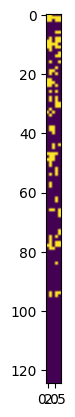

In [ ]:
plt.imshow(labels)

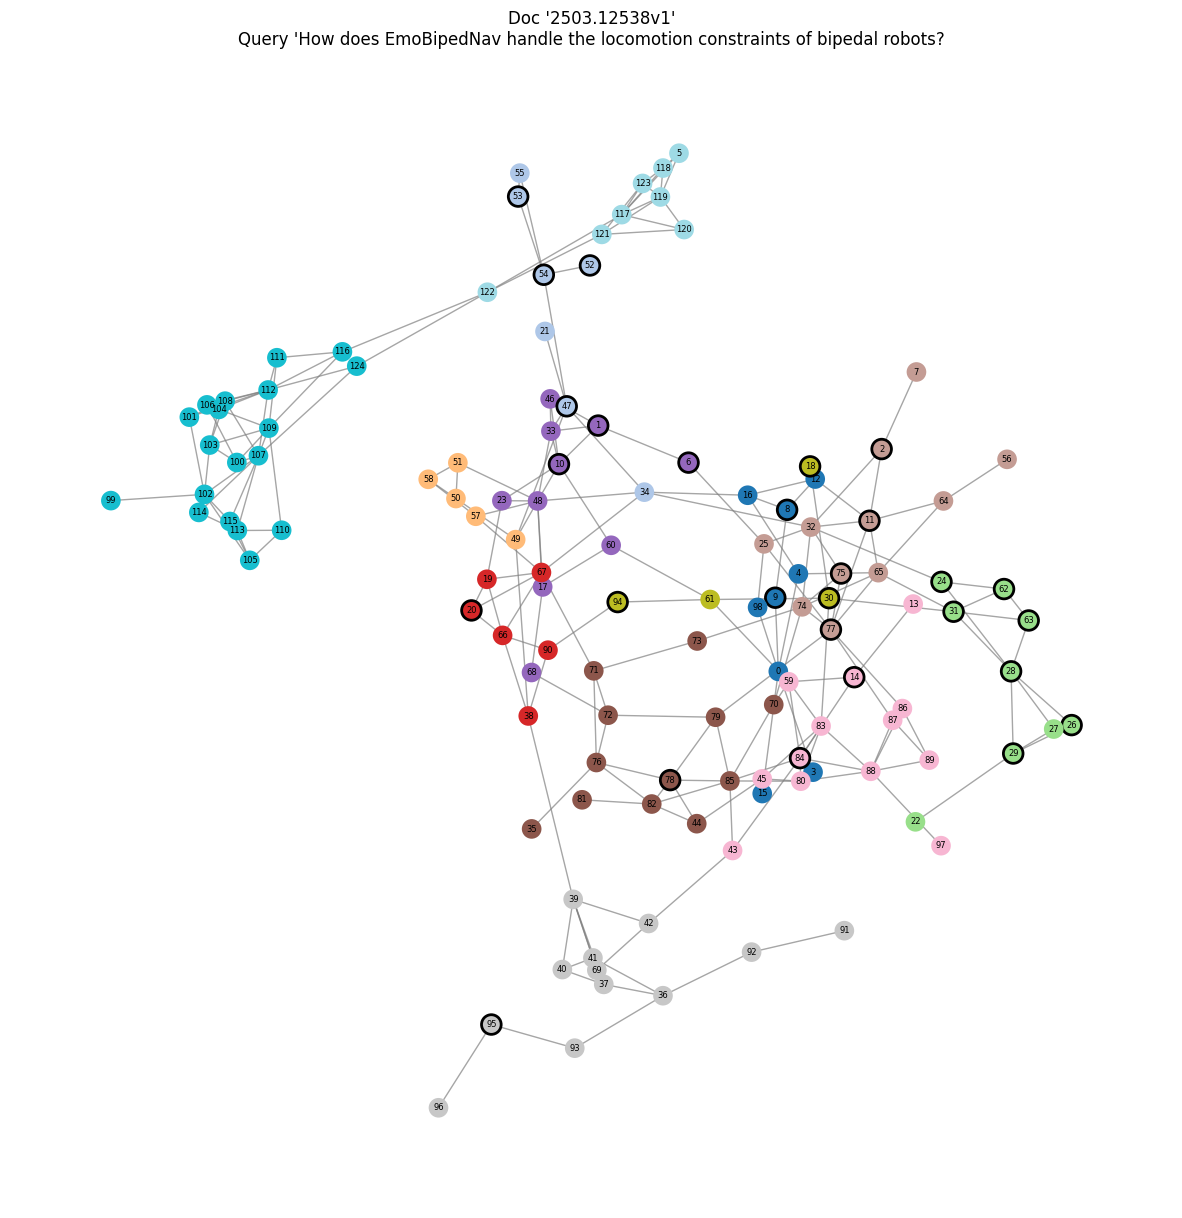

In [ ]:
node_border_widths = [G.nodes[node]['border_width'] for node in G.nodes()]
node_border_colors = [G.nodes[node]['border_color'] for node in G.nodes()]
node_labels = {node: node for node in G.nodes()}


pos = nx.spring_layout(G)
plt.figure(figsize=(15, 15)) # Adjust figure size for better visibility
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, linewidths=node_border_widths, edgecolors=node_border_colors) # Adjust node_size as needed
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7, edge_color="gray")
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=6, font_color="black")

plt.title(f"Doc '{doc_data['doc_name']}'\nQuery '{doc_data['metadata']['queries'][query_idx]}")
plt.axis("off") # Turn off the axis
plt.show()

### Relevance Evaluation
The relevance of the detected communities to the queries is evaluated using a language model. The results are visualized on the graph.

In [ ]:
G = nx.Graph()

threshold = 0.2
query_idx = 1

normalized_query_similarities = queries_results[:,query_idx] - np.min(queries_results[:,query_idx])
normalized_query_similarities /= np.max(normalized_query_similarities)

viridis = plt.cm.viridis

query_labels = labels[:, query_idx]
for i, chunk_label in enumerate(query_labels):
    border_width = 2 if chunk_label else 0
    color = np.array(viridis(normalized_query_similarities[i]))
    G.add_node(str(i),
               id=str(i), 
               border_width=border_width, 
               border_color='red', 
               color=color, 
               weight=normalized_query_similarities[i], 
               chunk_label=chunk_label,
               checked=False,
               qualified=False,
               selected=False)

for i, candidates in enumerate(zip(result_idxs, similarities)):
    l=0
    for candidate_idx, scores in zip(*candidates):
        if (scores > threshold) | (l==0):
            G.add_edge(str(i), str(candidate_idx))
        l+=1

In [ ]:
best_matches = [node['id'] for node in sorted([G.nodes[node] for node in G.nodes()], key=lambda x: x['weight'], reverse=True)][:20]

#connectivity = nx.all_pairs_node_connectivity(G, nbunch=best_matches)

In [ ]:
best_matches = list(sorted(nx.betweenness_centrality(G), key=lambda x: nx.betweenness_centrality(G)[x], reverse=True))[:50]

In [ ]:
def shortest_path_length(G, source, target):
    try:
        return nx.shortest_path_length(G, source=source, target=target)
    except nx.NetworkXNoPath:
        return 0

In [ ]:
path_len_threshold = 2
selected_nodes = []
frozen_nodes = []

for candidate_node in best_matches:
    if candidate_node not in frozen_nodes:
        considered_nodes = [node for node in best_matches if (node not in frozen_nodes) and (node != candidate_node) and (node not in selected_nodes)]

        frozen_nodes.extend([node for node in considered_nodes if 0 < shortest_path_length(G, candidate_node, node) <= path_len_threshold])
        selected_nodes.append(candidate_node)

print(f"Selected nodes: {len(selected_nodes)}")
print(f"Frozen nodes: {len(frozen_nodes)}")

Selected nodes: 11
Frozen nodes: 39


In [ ]:
connectivity['100']

{'76': 0,
 '2': 0,
 '9': 0,
 '65': 0,
 '75': 0,
 '15': 0,
 '24': 0,
 '109': 4,
 '3': 0,
 '4': 0,
 '30': 0,
 '14': 0,
 '0': 0,
 '102': 4,
 '103': 4,
 '1': 0,
 '7': 0,
 '107': 4,
 '11': 0}

In [ ]:
nx.shortest_path(G, '100', '103')

['100', '103']

In [ ]:
[G.nodes[node] for node in nx.all_neighbors(G, '14')]

[{'id': '13',
  'border_width': 0,
  'border_color': 'red',
  'color': array([0.221989, 0.339161, 0.548752, 1.      ]),
  'weight': np.float64(0.2692887493075035),
  'chunk_label': np.int64(0),
  'checked': False,
  'qualified': False,
  'selected': False},
 {'id': '84',
  'border_width': 2,
  'border_color': 'red',
  'color': array([0.278826, 0.17549 , 0.483397, 1.      ]),
  'weight': np.float64(0.12842627988773153),
  'chunk_label': np.int64(1),
  'checked': False,
  'qualified': False,
  'selected': False},
 {'id': '59',
  'border_width': 0,
  'border_color': 'red',
  'color': array([0.263663, 0.237631, 0.518762, 1.      ]),
  'weight': np.float64(0.1763901476387157),
  'chunk_label': np.int64(0),
  'checked': False,
  'qualified': False,
  'selected': False}]

In [ ]:
selected_nodes

['0', '75', '100', '14', '1', '76']

In [ ]:
selected_nodes = []

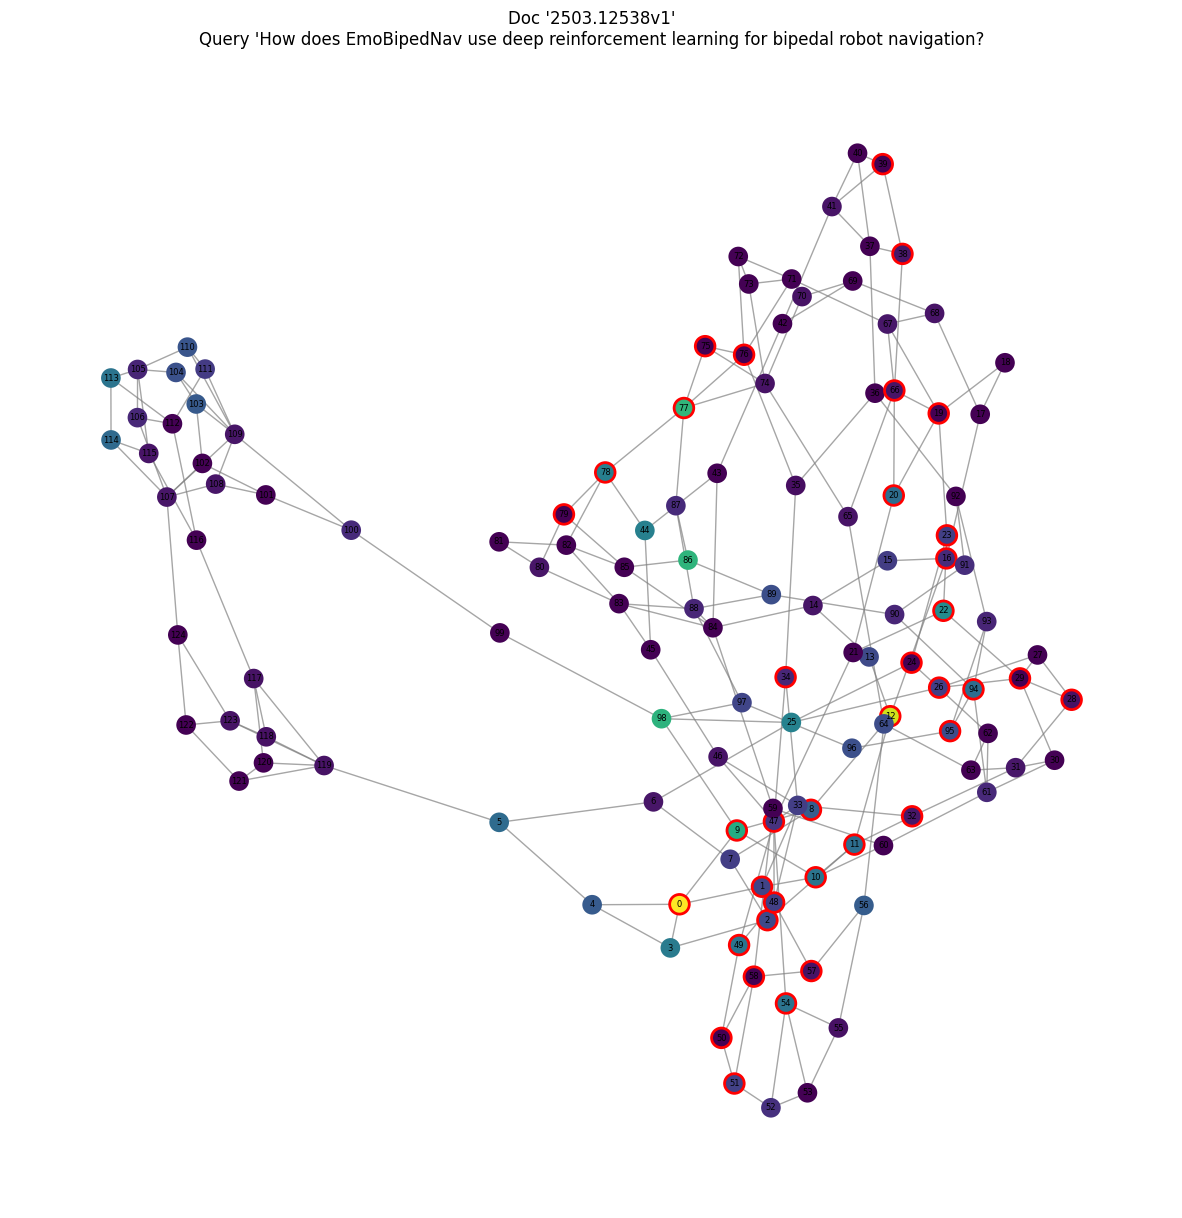

In [ ]:
red = np.array([1,1,1,1]).astype(np.float32)
node_colors = [G.nodes[node]['color'] if node not in selected_nodes else red for node in G.nodes()]
node_border_widths = [G.nodes[node]['border_width'] for node in G.nodes()]
node_border_colors = [G.nodes[node]['border_color'] for node in G.nodes()]
# Get node labels (the node names)
node_labels = {node: node for node in G.nodes()}

# Choose a layout algorithm (e.g., spring layout for a more natural look)
pos = nx.spring_layout(G)

# 5. Draw the graph
plt.figure(figsize=(15, 15)) # Adjust figure size for better visibility

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, linewidths=node_border_widths, edgecolors=node_border_colors) # Adjust node_size as needed

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7, edge_color="gray")

# Draw node labels
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=6, font_color="black")

plt.title(f"Doc '{doc_data['doc_name']}'\nQuery '{doc_data['metadata']['queries'][query_idx]}")
plt.axis("off") # Turn off the axis
plt.show()

In [ ]:
doc_data['chunks'][55]

'13. Liu, Q., Chen, C., Qin, J., Dou, Q., Heng, P.A.: Feddg: Federated domain gener-\nalization on medical image segmentation via episodic learning in continuous fre-\nquency space. In: Proceedings of the IEEE/CVF Conference on Computer Vision\nand Pattern Recognition. pp. 1013–1023 (2021)\n14. McMahan, B., Moore, E., Ramage, D., Hampson, S., y Arcas, B.A.:\nCommunication-Efficient Learning of Deep Networks from Decentralized Data. In:\nArtificial intelligence and statistics. pp. 1273–1282. PMLR (2017)\n15. Naylor, P., Laé, M., Reyal, F., Walter, T.: Segmentation of nuclei in histopathology'

## Comprehensive Query Answering
A comprehensive answer to the query is generated using the document content and the detected communities. The answer includes references to the relevant parts of the document.

In [582]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()

# Load data
doc_data = chunker(eval_docs[9])
print(f"Loaded document: {doc_data['doc_name']} with {len(doc_data['chunks'])} chunks.")

eval_data = data_handler.get_eval_file(doc_data['doc_name'])
labels = np.array([chunk_spec['labels'] for chunk_spec in eval_data['chunks_eval']]).astype(int)

# Get TF-IDF array for chunks
sentences = doc_data['chunks']
tfidf_array = vectorizer.fit_transform(sentences)

Loaded document: 2503.12538v1 with 125 chunks.


In [583]:
k = 3

# Calculate chunks self similarity
sentences_vector = vectorizer.transform(sentences)
results = cosine_similarity(tfidf_array, sentences_vector)

results *= 1-np.eye(results.shape[0])
results += np.eye(results.shape[0], k=1) + np.eye(results.shape[0], k=-1) # add neighbors as forced edges

result_idxs = results.T.argsort()[:,-k:][:,::-1]
similarities = np.take_along_axis(results.T, result_idxs, axis=1)

In [584]:
# Construct a graph of chunks based on their self-similarity

threshold = 0.2
query_idx = 1

G = nx.Graph()
query_labels = labels[:, query_idx]
for i, chunk_label in enumerate(query_labels):
    border_width = 2 if chunk_label else 0
    G.add_node(str(i), border_width=border_width, border_color='black')

for i, candidates in enumerate(zip(result_idxs, similarities)):
    l=0
    for candidate_idx, scores in zip(*candidates):
        if (scores > threshold) | (l==0):
            G.add_edge(str(i), str(candidate_idx), weight=scores)
        l+=1

In [585]:
communities = nx.community.louvain_communities(G, seed=123, resolution=2.0)
print(f"Number of communities: {len(communities)}")

Number of communities: 15


In [586]:
[len(community) for community in communities]

[10, 7, 9, 7, 9, 5, 12, 7, 5, 9, 10, 11, 11, 5, 8]

In [587]:
clusters_labels = []

for cluster_idxs in communities:
    cluster_labels = labels[[int(i) for i in cluster_idxs]]
    # Aggregate labels by summing them up
    aggregated_labels = np.sum(cluster_labels, axis=0)

    clusters_labels.append(aggregated_labels)

clusters_labels = np.stack(clusters_labels, axis=0)
print(f"Clusters labels shape: {clusters_labels.shape}")

clusters_labels

Clusters labels shape: (15, 5)


array([[4, 5, 1, 5, 5],
       [2, 4, 1, 3, 4],
       [3, 5, 2, 3, 0],
       [0, 4, 0, 5, 2],
       [1, 3, 4, 0, 0],
       [0, 0, 2, 0, 1],
       [2, 8, 3, 4, 0],
       [0, 0, 0, 2, 0],
       [0, 1, 1, 0, 3],
       [1, 5, 1, 3, 4],
       [0, 0, 0, 1, 0],
       [0, 2, 0, 2, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [588]:
from langchain_text_splitters import CharacterTextSplitter

"""tiny_chunker = RecursiveCharacterTextSplitter(
            chunk_size=200,
            chunk_overlap=50,
            length_function=len,
        )"""

tiny_chunker = CharacterTextSplitter.from_tiktoken_encoder(
    encoding_name="cl100k_base", chunk_size=1, chunk_overlap=0
)

In [589]:
from langchain_text_splitters import TokenTextSplitter

tiny_chunker = TokenTextSplitter(chunk_size=40, chunk_overlap=0)

In [509]:
tiny_chunker.split_text(doc_data['chunks'][1])

['environments, including pedestrian interactions and social cues,\nsuch as emotions, these challenges become even more pronounced.\nTo address these coupled problems, we propose a two-stage\npipeline that',
 ' considers both bipedal locomotion constraints\nand complex social environments. Specifically, social navigation\nscenarios are represented using sequential LiDAR grid maps\n(LGMs), from which we extract',
 ' latent features, including collision\nregions, emotion-related discomfort zones, social interactions,\nand the spatio-temporal dynamics of evolving environments.']

In [590]:
from langchain_core.documents import Document

def get_community_chunk(community_set, chunks):
    """
    Retrieves chunks for a given community set.
    
    Args:
        community_set (set): Set of chunk indexes in the community.
        chunks (list): List of all chunks.
    
    Returns:
        list: Chunks belonging to the community.
    """
    return [chunks[int(i)] for i in community_set]

def get_n_furthest_points(similarity_matrix, n, seed=None):
    """
    Finds n furthest points iteratively starting from a random initial point.

    Args:
        similarity_matrix (np.ndarray): Affinity matrix of similarities.
        n (int): Number of furthest points to retrieve.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        list: Indices of the n furthest points.
    """
    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)

    # Invert similarity matrix to treat low similarity as high distance
    distance_matrix = 1 - similarity_matrix

    # Randomly select the initial point
    initial_point = np.random.choice(distance_matrix.shape[0])
    selected_points = [initial_point]

    for _ in range(n - 1):
        # Calculate distances from the set of selected points
        distances_to_selected = np.min(distance_matrix[selected_points], axis=0)

        # Find the index of the furthest point
        furthest_point = np.argmax(distances_to_selected)

        # Add the furthest point to the selected points
        selected_points.append(furthest_point)

    return selected_points


def get_cummunity_representation(community_chunks, n_samples=8):

    community_tiny_chunks = [tiny_chunk for chunk in community_chunks for tiny_chunk in tiny_chunker.split_text(chunk)]

    community_embeddings = np.array(embedding_model.embed_documents(community_tiny_chunks)).astype(np.float32)
    community_similarities = embs_cosine_similarity(community_embeddings, community_embeddings)

    community_clustering = SpectralClustering(
        n_clusters=min(len(community_chunks), n_samples),
        affinity='precomputed',
        eigen_solver='arpack',
        assign_labels='cluster_qr'
        ).fit(community_similarities)

    community_clusters_idxs = group_points_by_cluster(community_clustering.labels_)


    community_representation_idxs = [get_centroid_representative_chunk(cl_idxs, community_embeddings) for cl_idxs in community_clusters_idxs]
    community_representations = [community_tiny_chunks[idx] for idx in community_representation_idxs]

    return community_representations

In [591]:
communities_chunks = [get_community_chunk(community_set, doc_data['chunks']) for community_set in communities]

In [592]:
communities_representations = [get_cummunity_representation(community_chunks, n_samples=8) for community_chunks in communities_chunks]


In [593]:
for chunk in [chunk for community in communities_representations for chunk in community]:
    print(chunk)

based pipelines can account for tracking errors and constraints
of low-level controllers, as well as direct interactions between
pedestrians and bipedal robots, by directly training with full-
body
tive environments. We represent the environment with an
image-based observation of sequential LiDAR grid maps
)
, we present an emotion-aware navigation
framework – EmoBipedNav – using deep reinforcement learn-
ing (DRL) for bipedal robots walking in socially interac-

environments within social contexts. However, achieving safe
and socially aware navigation remains a formidable challenge,
originating from the intricate dynamics of bipedal robots,
limited maneuvering capabilities in dynamic
i-
gation trajectories with reduced-order models (ROMs) at first,
and then tracking the trajectories with locomotion controllers
based on full-order dynamics [15]
iz Shamsah 2, Anqi Wu 3, Seth Hutchinson 4, and Ye Zhao 1
Abstract—This study presents an emotion-aware navigation
framework – EmoBipedNav – us

In [540]:
doc_data['metadata']['queries']

['What is Federated SAM (FedSAM)?',
 'What is Federated SAM with Medical SAM Adapter (FedMSA)?',
 'How does FedFMS maintain privacy while achieving comparable performance to centralized training?',
 'What are the communication and training efficiency benefits of FedMSA?',
 'Compare the performance of FedFMS with centralized training methods in medical image segmentation.']

In [597]:
from typing_extensions import List, Dict, Any, TypedDict, Annotated
from pydantic import BaseModel

class PhrasesModel(BaseModel):
    phrases: List[str]

prompt = """
Given the following query, research paper summary and some small parts of the research paper prepare a list of phrases for a search of the most relevant parts of the research paper that can answer the query.
Return up to 20 phrases that addresses different aspects of the paper that may be useful for answering the query.
---
**Query**
{query}
---
**Summary**
{summary}
---
**Chunks**
{chunks}
---
"""

In [601]:
chunks = '/n-/n'.join([chunk for community in communities_representations for chunk in community])
filled_prompt = prompt.format(query=doc_data['metadata']['queries'][query_idx], chunks=chunks, summary=doc_data['metadata']['summary'])

phrases = get_llm(llm_model='google').with_structured_output(PhrasesModel).invoke(filled_prompt).phrases

In [602]:
phrases

['deep reinforcement learning for bipedal robots',
 'emotion-aware navigation framework',
 'EmoBipedNav',
 'bipedal locomotion constraints',
 'socially interactive environments',
 'two-stage pipeline',
 'LiDAR grid maps (LGMs)',
 'latent features',
 'collision regions',
 'emotion-related discomfort zones',
 'social interactions',
 'spatio-temporal dynamics',
 'reduced-order models (ROMs)',
 'full-order dynamics',
 'locomotion controller',
 'tracking errors',
 'model-based planners',
 'DRL-based baselines',
 'full-body simulation of Digit',
 'observation space and DRL network architecture']

In [560]:
from typing_extensions import List, Dict, Any, TypedDict, Annotated
from pydantic import BaseModel

class RelevanceAnswerModel(BaseModel):
    relevant: bool

prompt = """
Given the following query and some chunks from some part of a research paper decide whether that part may be relevant to the query or not.
As irrelevant mark only those which you are sure won't be useful for answering the query.
---
**Query**
{query}
---
**Chunks**
{chunks}
---
"""

In [561]:
query_idx = 4

In [562]:
prompts = [prompt.format(query=doc_data['metadata']['queries'][query_idx], chunks='\n\n'.join(community_representation)) for community_representation in communities_representations]

In [563]:
communities_relevance_eval = get_llm(llm_model='google').with_structured_output(RelevanceAnswerModel).batch(prompts)

In [564]:
np.array([x.relevant for x in communities_relevance_eval]).astype(int), clusters_labels[:,query_idx]

(array([1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0]),
 array([1, 0, 0, 1, 2, 3, 5, 3, 1, 2, 0, 0]))

In [565]:
G = nx.Graph()

threshold = 0.2

query_labels = labels[:, query_idx]
for i, chunk_label in enumerate(query_labels):
    border_width = 2 if chunk_label else 0
    G.add_node(str(i), border_width=border_width, border_color='black')

for i, candidates in enumerate(zip(result_idxs, similarities)):
    l=0
    for candidate_idx, scores in zip(*candidates):
        if (scores > threshold) | (l==0):
            G.add_edge(str(i), str(candidate_idx), weight=scores)
        l+=1

In [566]:
communities_num = len(communities)

# colors for each community
colors = plt.get_cmap('tab20', communities_num).colors

# Create a color map for the nodes based on their community
node_colors = []
for i, community in enumerate(communities):
    community_eval = communities_relevance_eval[i].relevant
    for node in community:
        node_colors.append({'id': int(node), 'color': 'green' if community_eval else 'red'})

# sort colors by node id
node_colors = [node['color'] for node in sorted(node_colors, key=lambda x: x['id'])]

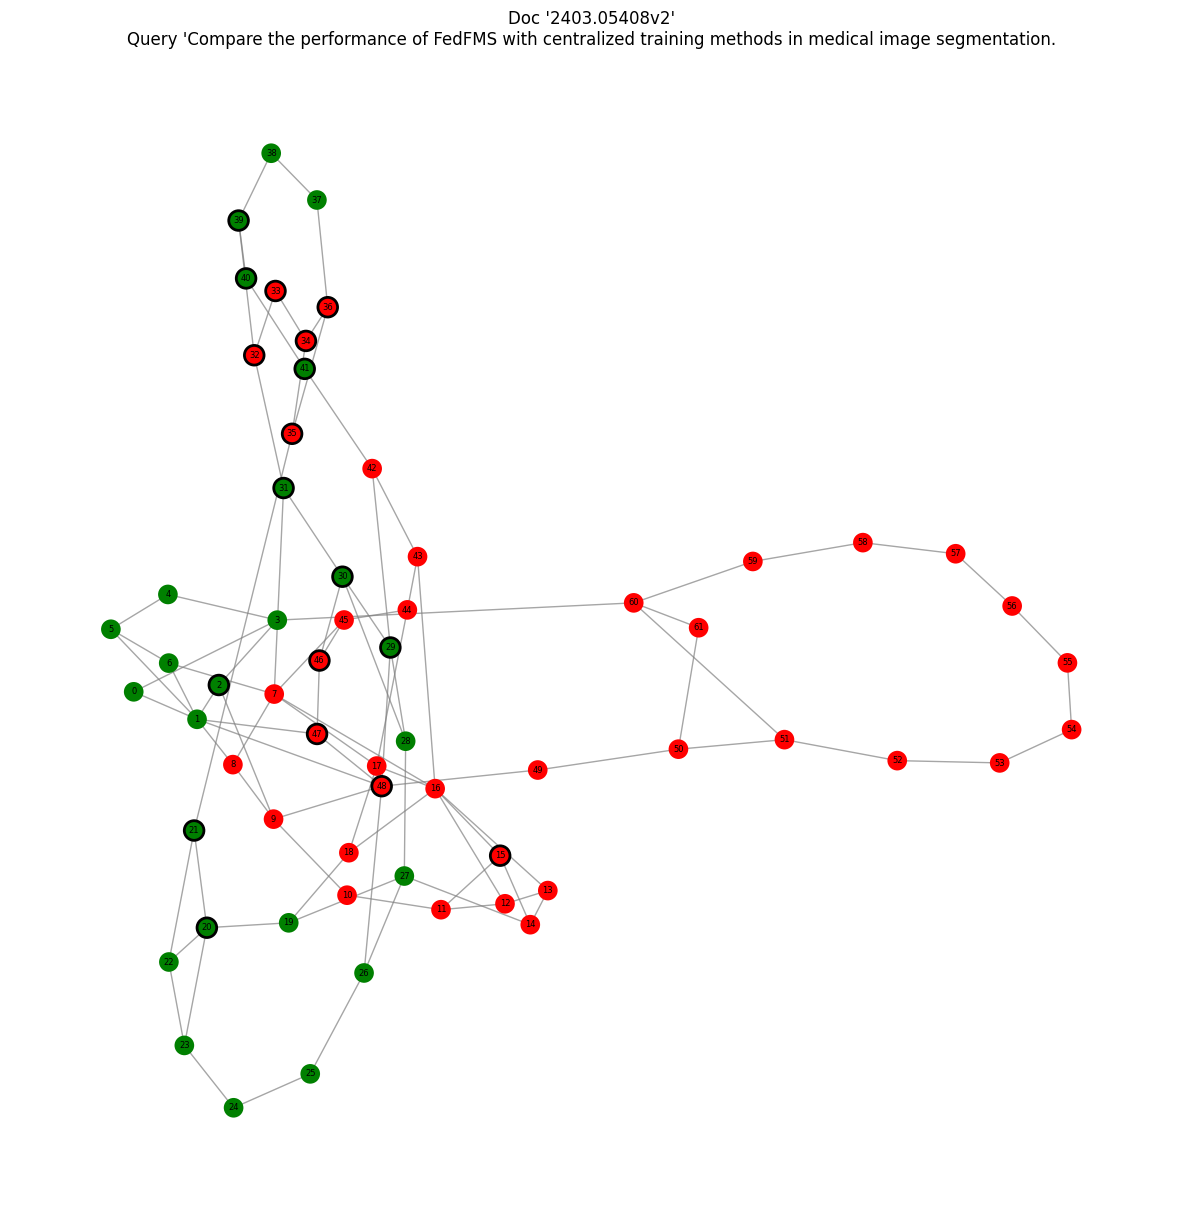

In [567]:
node_border_widths = [G.nodes[node]['border_width'] for node in G.nodes()]
node_border_colors = [G.nodes[node]['border_color'] for node in G.nodes()]
node_labels = {node: node for node in G.nodes()}


pos = nx.spring_layout(G)
plt.figure(figsize=(15, 15)) # Adjust figure size for better visibility
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, linewidths=node_border_widths, edgecolors=node_border_colors) # Adjust node_size as needed
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7, edge_color="gray")
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=6, font_color="black")

plt.title(f"Doc '{doc_data['doc_name']}'\nQuery '{doc_data['metadata']['queries'][query_idx]}")
plt.axis("off") # Turn off the axis
plt.show()

In [550]:
for chunk in doc_data['chunks'][20:25]:
    for line in chunk.split('\n'):
        print(line)
    print("\n---\n")

– ProstateCancer.ExtractedfrompublicprostatecancerMRIimagingdatasets
from various medical institutions [12,10] and NCI-ISBI 2013.
– Brain Tumor. Derived from FeTS2022 [18], which is a collection of multi-
institutional clinical acquisition mp-MRI scans of gliomas. The segmentation
target we use is the GD-enhancing tumor (ET - label 4) on T1ce images.
FedFMS 5
G1020 (1020 slices)
(2481 slices)
          
Ground Truth     FedMSA(Ours)           MSA            FedSAM(Ours)           SAM
0.892 0.758 
0.954 0.922 0.941 0.963 
0.948 0.920 0.931 0.949 
0.942 0.935 0.949 0.970

---

0.955 0.922 0.933 0.965 
0.800 0.867 0.733 0.772 
0.732 0.867 0.730 0.727 
0.831 0.920 0.767 0.733 
0.812 0.936 0.637 0.765 
0.934 0.878 
0.871 0.813 
0.903 0.806 
0.860 0.875 
0.875 0.856 0.873 0.819 
0.882 0.843 0.861 0.815 
0.870 0.834 0.859 0.854 
0.844 0.847 0.872 0.834
0.766 0.849 
0.775 0.751 
0.772 0.832 
0.764 0.730 
0.753 
0.698 
0.753 
0.950 
0.754 0.893 0.925 0.972 0.797 0.752 
0.950 0.917 0.780 0.900 

In [610]:
tokenizer = TokenTextSplitter(chunk_size=1, chunk_overlap=0)

len(tokenizer.split_text(doc_data['content']))/1e6*0.20*4

0.0147744

In [612]:
prompt = """
Analyze the research paper and answer comprehensively with explanations to the query.
At the end add list of references used in the answer.
---
**Query**
{query}
---
**Content**
{content}
---
**Answer**
"""

In [614]:
result = get_llm(llm_model='google').invoke(
    prompt.format(query=doc_data['metadata']['queries'][query_idx], content=doc_data['content'])
).content

In [615]:
print(doc_data['metadata']['queries'][query_idx])

How does EmoBipedNav use deep reinforcement learning for bipedal robot navigation?


In [616]:
for line in result.split('\n'):
    print(line)

The EmoBipedNav framework utilizes deep reinforcement learning (DRL) to enable bipedal robots to navigate social environments while being aware of pedestrian emotions. Here's a breakdown of how it works:

**1. Problem Formulation as a POMDP:**

*   The social navigation problem is formulated as a Partially Observable Markov Decision Process (POMDP). This is because the robot doesn't have full knowledge of the environment, particularly the intentions and future trajectories of pedestrians.
*   The POMDP is defined by a tuple (S, O, A, Γ, R, γ) where:
    *   **S (State Space):** Includes the goal position relative to the robot and the robot's previous action. These are fully observable.
    *   **O (Observation Space):** Consists of sequential LiDAR Grid Maps (LGMs) which provide partial information about the environment.
    *   **A (Action Space):** The robot's actions, defined by the sagittal center-of-mass (CoM) speed and heading angle of the robot's torso.
    *   **Γ (State Transi

## Keywords Search
Keywords are generated for the query to facilitate searching for relevant information in the document. The keywords are used to retrieve and rank relevant chunks.

In [261]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()

# Load data
doc_data = chunker(eval_docs[9])
print(f"Loaded document: {doc_data['doc_name']} with {len(doc_data['chunks'])} chunks.")

eval_data = data_handler.get_eval_file(doc_data['doc_name'])
labels = np.array([chunk_spec['labels'] for chunk_spec in eval_data['chunks_eval']]).astype(int)

# Get TF-IDF array for chunks
sentences = doc_data['chunks']
tfidf_array = vectorizer.fit_transform(sentences)

Loaded document: 2503.12538v1 with 125 chunks.


In [264]:
doc_data['metadata']['queries']

['What is EmoBipedNav and what problem does it solve?',
 'How does EmoBipedNav use deep reinforcement learning for bipedal robot navigation?',
 'What are the key features extracted from LiDAR grid maps in EmoBipedNav?',
 'How does EmoBipedNav handle the locomotion constraints of bipedal robots?',
 'How does EmoBipedNav compare to model-based planners and DRL-based baselines in social navigation?']

In [262]:
from typing_extensions import List, Dict, Any, TypedDict, Annotated
from pydantic import BaseModel 

class keyword_model(BaseModel):
    keywords: List[str]

query_idx = 1

keyword_prompt = f"""
# **TASK**
Write up to 10 search keywords for a given query that will help to find relevant information in the document.
You can either extract keywords from the query or use your own knowledge or intuition to generate them so they will match answer to the query.
Use document summary for better understanding.
---
# **SUMMARY**
{doc_data['metadata']['summary']}
---
# **QUERY**
{doc_data['metadata']['queries'][query_idx]}
---
"""

In [263]:
keywords = get_llm('google').with_structured_output(keyword_model).invoke(keyword_prompt)
print("Keywords:", keywords.keywords)

Keywords: ['EmoBipedNav', 'deep reinforcement learning', 'bipedal robot', 'navigation', 'socially interactive environments', 'locomotion constraints', 'social cues', 'emotion-related discomfort zones', 'LiDAR grid maps', 'reduced-order models']


In [265]:
k = 3

sentences_vector = vectorizer.transform(sentences)
results = cosine_similarity(tfidf_array, sentences_vector)

results *= 1-np.eye(results.shape[0])
#results += np.eye(results.shape[0], k=1) + np.eye(results.shape[0], k=-1)

result_idxs = results.T.argsort()[:,-k:][:,::-1]
similarities = np.take_along_axis(results.T, result_idxs, axis=1)

print("result_idxs:", result_idxs.shape)
print("similarities:", similarities.shape)

result_idxs: (125, 3)
similarities: (125, 3)


In [267]:
k_queries = 4

queries_vector = vectorizer.transform(keywords.keywords)
queries_results = cosine_similarity(tfidf_array, queries_vector)

queries_result_idxs = queries_results.T.argsort()[:,-k_queries:][:,::-1]
queries_similarities = np.take_along_axis(queries_results.T, queries_result_idxs, axis=1)

print("queries results", queries_results.shape)
print("queries_result_idxs:", queries_result_idxs.shape)
print("queries_similarities:", queries_similarities.shape)

queries results (125, 10)
queries_result_idxs: (10, 4)
queries_similarities: (10, 4)


In [268]:
G = nx.Graph()

threshold = 0.2
query_idx = 1

normalized_query_similarities = queries_results[:,query_idx] - np.min(queries_results[:,query_idx])
normalized_query_similarities /= np.max(normalized_query_similarities)

viridis = plt.cm.viridis

query_labels = labels[:, query_idx]
for i, chunk_label in enumerate(query_labels):
    border_width = 2 if chunk_label else 0
    color = np.array(viridis(normalized_query_similarities[i]))
    G.add_node(str(i), border_width=border_width, border_color='red', color=color)

for i, candidates in enumerate(zip(result_idxs, similarities)):
    for candidate_idx, scores in zip(*candidates):
        if scores > threshold:
            G.add_edge(str(i), str(candidate_idx))

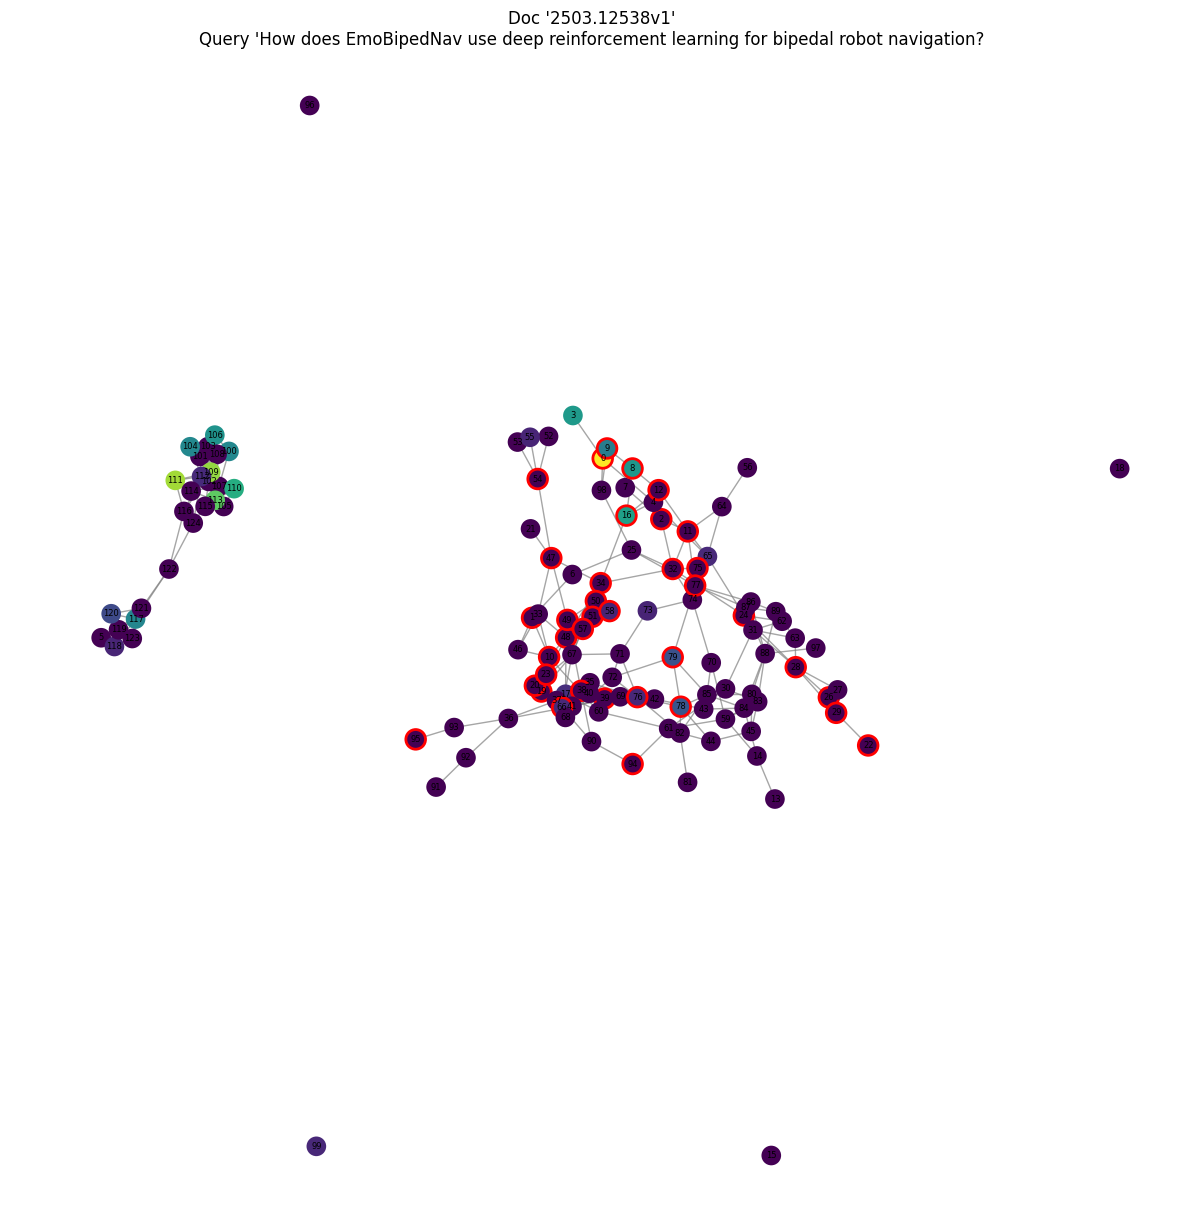

In [269]:
node_colors = [G.nodes[node]['color'] for node in G.nodes()]
node_border_widths = [G.nodes[node]['border_width'] for node in G.nodes()]
node_border_colors = [G.nodes[node]['border_color'] for node in G.nodes()]
# Get node labels (the node names)
node_labels = {node: node for node in G.nodes()}

# Choose a layout algorithm (e.g., spring layout for a more natural look)
pos = nx.spring_layout(G)

# 5. Draw the graph
plt.figure(figsize=(15, 15)) # Adjust figure size for better visibility

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, linewidths=node_border_widths, edgecolors=node_border_colors) # Adjust node_size as needed

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7, edge_color="gray")

# Draw node labels
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=6, font_color="black")

plt.title(f"Doc '{doc_data['doc_name']}'\nQuery '{doc_data['metadata']['queries'][query_idx]}")
plt.axis("off") # Turn off the axis
plt.show()